In [8]:
from netCDF4 import Dataset
import numpy as np
import dateutil.parser
import matplotlib.pyplot as plt
import os
from glob import glob
import tqdm
import pandas as pd
import datetime



import matplotlib.pyplot as plt
#import seaborn as sns
from tqdm import tqdm 
from pathlib import Path # Path library

#import statsmodels.api as sm

sonde_dir = '../data/MOSAiC/sondes/'

result = [y for x in os.walk(sonde_dir) for y in glob(os.path.join(x[0], '*.nc'))]

In [9]:
Dataset(result[0]).variables.keys()

dict_keys(['time', 'alt', 'alt_uc', 'alt_amsl', 'alt_amsl_uc', 'alt_amsl_uc_ucor', 'alt_amsl_uc_tcor', 'alt_wgs84', 'alt_wgs84_uc', 'alt_wgs84_uc_ucor', 'alt_wgs84_uc_tcor', 'alt_gph', 'alt_gph_uc', 'alt_gph_uc_ucor', 'alt_gph_uc_tcor', 'lon', 'lon_uc', 'lon_uc_ucor', 'lon_uc_tcor', 'lat', 'lat_uc', 'lat_uc_ucor', 'lat_uc_tcor', 'press', 'press_uc', 'press_sens', 'press_sens_uc', 'press_sens_uc_ucor', 'press_sens_uc_tcor', 'press_sens_uc_tcor_cal', 'press_sens_uc_ucor_sm', 'press_sens_corr', 'press_sens_corr_cal', 'press_sens_corr_sm', 'press_gnss', 'press_gnss_uc', 'press_gnss_uc_ucor', 'press_gnss_uc_tcor', 'temp', 'temp_uc', 'temp_uc_ucor', 'temp_uc_scor', 'temp_uc_tcor', 'temp_uc_rad', 'temp_uc_ucor_rad', 'temp_uc_scor_rad', 'temp_uc_tcor_rad', 'temp_uc_tcor_cal', 'temp_uc_ucor_sm', 'temp_corr', 'temp_corr_rad', 'temp_corr_sm', 'temp_res', 'rh', 'rh_uc', 'rh_uc_ucor', 'rh_uc_tcor', 'rh_uc_tlc', 'rh_uc_ucor_tlc', 'rh_uc_tcor_tlc', 'rh_uc_tcor_cal', 'rh_uc_ucor_sm', 'rh_uc_tcor_tint'

In [10]:
list_of_dicts = []

for f in tqdm(result[:]):
    
    d = Dataset(f)
    datestring = d['time'].units.split(' ')[-1]
    dt0 = dateutil.parser.parse(datestring)
    lon0, lat0 = float(d['lon'][0]), float(d['lat'][0])

    alt = np.array(d['alt'])
    temp = np.array(d['temp'])-273.15
    wind = np.array(d['wspeed'])
    
    # Calculate inversion heights and strengths
    
    t0 = np.nanmedian(temp[(alt<10) & (alt>-10)])
    inversion_height = alt[np.argmax(temp)]
    inversion_strength = np.max(temp) - t0
    
    # Calculate low-level stability (850-2m tempreture)
    
    press = np.array(d['press'])
    t850hpa = temp[np.argmin(np.abs(press-850))]
    t2m = temp[np.argmin(np.abs(alt-2))]
    lls = t850hpa - t2m
    
    rh = np.asarray(d['rh'])/100
    rh_sub_850 = np.nanmean(rh[press<851])
    
    w0 = np.nanmedian(wind[(alt<10) & (alt>-10)])
    w850 = wind[np.argmin(np.abs(press-850))]
    

    dic = {'t0':t0,
           'dt0':dt0,
           'month':dt0.month,
           'lon':lon0,
           'lat':lat0,
           'inversion_strength':inversion_strength,
           'inversion_height':inversion_height,
           'low_level_stability':lls,
           't_850hpa':t850hpa,
           'rh_sub_850':rh_sub_850,
           'surf_wind_velocity':w0,
           'wind_shear':w850-w0,
          }
    
    list_of_dicts.append(dic)
    
df = pd.DataFrame(list_of_dicts)

  0%|          | 3/624 [00:00<01:22,  7.52it/s]/Users/ali/miniconda3/envs/duffpy/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
 76%|███████▌  | 475/624 [00:56<00:17,  8.73it/s]/var/folders/_3/z3f8pgvj6fq3_sgjypm06h6r0000gn/T/ipykernel_54115/2937823051.py:16: RuntimeWarning: All-NaN slice encountered
  t0 = np.nanmedian(temp[(alt<10) & (alt>-10)])
100%|██████████| 624/624 [01:14<00:00,  8.40it/s]


In [11]:
df_sondes = df.copy()

In [12]:
df_sondes

,t0,dt0,month,lon,lat,inversion_strength,inversion_height,low_level_stability,t_850hpa,rh_sub_850,surf_wind_velocity,wind_shear
0,-27.561951,2020-02-16 22:43:34.370000+00:00,2,79.627572,88.069349,6.222931,579.749268,5.231018,-22.340195,0.273186,6.142340,1.432100
1,-23.267990,2020-02-24 16:52:23.852000+00:00,2,52.539957,88.584139,NaN,17379.167969,5.955933,-17.312057,0.339253,12.822152,6.246299
2,-24.137451,2020-02-25 16:51:36.069000+00:00,2,44.385008,88.549541,6.794998,570.027283,4.590500,-19.546951,0.224312,12.269664,9.219295
3,NaN,2020-02-15 22:44:46.693000+00:00,2,79.744262,88.067856,NaN,494.141846,10.335236,-26.076447,0.228418,NaN,NaN
4,-29.049454,2020-02-26 16:49:32.343000+00:00,2,39.222764,88.473025,8.806351,890.785461,8.317902,-20.591187,0.274485,8.542025,4.615234
...,...,...,...,...,...,...,...,...,...,...,...,...
619,NaN,2020-01-03 22:50:04.390000+00:00,1,115.546444,86.954808,NaN,12420.911133,6.965759,-17.073944,0.278028,NaN,NaN
620,-26.243912,2020-01-26 10:54:35.932000+00:00,1,93.679801,87.415841,6.904388,513.987671,4.768631,-21.475281,0.253483,5.623881,4.731204
621,-25.514267,2020-01-04 22:49:24.713000+00:00,1,115.339948,87.040306,6.743668,1154.372803,6.662201,-18.852066,0.207381,5.384744,1.662308
622,NaN,2020-01-24 04:55:36.050000+00:00,1,93.267425,87.424958,NaN,434.193237,10.026321,-21.034790,0.289284,NaN,NaN


In [13]:
df_c = df_sondes.dropna(subset = ['dt0', 'low_level_stability'])

df_c['dt_'] = [x.to_datetime64() for x in df_c['dt0']]

df_c = df_c[df_c['dt_'] < datetime.datetime(2020,7,1)]
df_c = df_c[df_c['dt_'] > datetime.datetime(2019,10,15)]

df_c.to_csv('../data/tables/MOSAiC_sondes.csv')

/var/folders/_3/z3f8pgvj6fq3_sgjypm06h6r0000gn/T/ipykernel_54115/3348704013.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_c['dt_'] = [x.to_datetime64() for x in df_c['dt0']]


In [ ]:
df_c = pd.read_csv('../data/tables/MOSAiC_sondes.csv')

In [14]:
df_c['time'] = df_c['dt0']
df_sondes_sorted = df_c.set_index('time').sort_index()
df_sondes_sorted

,t0,dt0,month,lon,lat,inversion_strength,inversion_height,low_level_stability,t_850hpa,rh_sub_850,surf_wind_velocity,wind_shear,dt_
time,,,,,,,,,,,,,
2019-10-31 22:55:09.757000+00:00,-24.483231,2019-10-31 22:55:09.757000+00:00,10,123.109808,85.794717,7.719315,677.768738,3.039383,-21.432983,0.172249,3.089488,3.799795,2019-10-31 22:55:09.757
2019-11-01 04:56:50.315000+00:00,-18.683792,2019-11-01 04:56:50.315000+00:00,11,122.969024,85.808400,3.861588,414.938721,-4.954498,-23.888641,0.161843,1.846944,3.294203,2019-11-01 04:56:50.315
2019-11-01 10:55:53.717000+00:00,NaN,2019-11-01 10:55:53.717000+00:00,11,122.841171,85.819359,NaN,440.100037,-5.534912,-24.024567,0.161056,NaN,NaN,2019-11-01 10:55:53.717
2019-11-01 16:51:40.040000+00:00,-18.477798,2019-11-01 16:51:40.040000+00:00,11,122.771985,85.831256,1.833145,539.540283,-6.124939,-24.602737,0.184259,5.201878,-2.693986,2019-11-01 16:51:40.040
2019-11-01 22:53:41.759000+00:00,-18.432388,2019-11-01 22:53:41.759000+00:00,11,122.683449,85.838081,0.892715,519.692627,-6.787262,-25.219650,0.205715,1.418454,4.227781,2019-11-01 22:53:41.759
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-30 16:54:40.827000+00:00,-28.804062,2020-03-30 16:54:40.827000+00:00,3,13.282623,85.370027,8.152771,454.131195,6.680191,-22.123871,0.178671,5.072469,6.569064,2020-03-30 16:54:40.827
2020-03-30 22:45:17.310000+00:00,-29.488251,2020-03-30 22:45:17.310000+00:00,3,13.429095,85.356679,8.784164,564.897217,7.987000,-21.287491,0.195274,6.540287,5.324797,2020-03-30 22:45:17.310
2020-03-31 04:50:43.813000+00:00,-29.847366,2020-03-31 04:50:43.813000+00:00,3,13.646492,85.333472,10.319397,817.890320,9.270493,-20.564697,0.255228,7.404456,8.000755,2020-03-31 04:50:43.813


In [3]:
### now read in tower data (slow)
import xarray as xr
import dask
ds_tower = xr.open_mfdataset('../data/MOSAiC/tower/*.nc')

In [5]:
ds_tower

<xarray.Dataset>
Dimensions:                     (time: 38880)
Coordinates:
  * time                        (time) datetime64[ns] 2019-10-15 ... 2020-09-...
Data variables: (12/220)
    base_time                   (time) datetime64[ns] 2019-10-15 ... 2020-09-18
    time_offset                 (time) datetime64[ns] dask.array<chunksize=(144,), meta=np.ndarray>
    lat_tower                   (time) float64 dask.array<chunksize=(144,), meta=np.ndarray>
    lon_tower                   (time) float64 dask.array<chunksize=(144,), meta=np.ndarray>
    tower_heading               (time) float64 dask.array<chunksize=(144,), meta=np.ndarray>
    mast_heading                (time) float64 dask.array<chunksize=(144,), meta=np.ndarray>
    ...                          ...
    sigW_10m                    (time) float64 dask.array<chunksize=(144,), meta=np.ndarray>
    sigW_mast                   (time) float64 dask.array<chunksize=(144,), meta=np.ndarray>
    bulk_Hs_10m                 (time) float64 dask.array<chunksize=(144,), meta=np.ndarray>
    bulk_Hl_10m                 (time) float64 dask.array<chunksize=(144,), meta=np.ndarray>
    bulk_Hl_Webb_10m            (time) float64 dask.array<chunksize=(144,), meta=np.ndarray>
    bulk_ustar                  (time) float64 dask.array<chunksize=(144,), meta=np.ndarray>
Attributes: (12/22)
    date_created:              Fri Feb  3 13:30:54 2023
    title:                     MOSAiC flux group data product
    contact:                   Matthew Shupe, University of Colorado, matthew...
    institution:               CIRES, University of Colorado and NOAA Physica...
    file_creator:              Michael R. Gallagher; Christopher J. Cox
    creator_email:             michael.r.gallagher@noaa.gov; christopher.j.co...
    ...                        ...
    instrument_heights:        Instruments were installed at nominal heights....
    quality_control:           Significant quality control is in place for th...
    qc_flags:                  -1 = No Data: Instrument was not functional an...
    wind_sector_qc_info_flag:  Quality control flags specifically for wind se...
    turbulence_qc_flags:       Applies to all derived EC-based turbulence par...
    bulk_qc_flags:             Applies to all derived bulk-based turbulence p...

In [55]:
# Extract the relevant variables.
T2m = ds_tower.temp_2m               # 2-m air temperature
LWdown = ds_tower.down_long_hemisp   # downwelling LW radiation
LWup = ds_tower.up_long_hemisp    # upwelling LW radiation
lat = ds_tower.lat_tower
lon = ds_tower.lon_tower
wspeed_u_2m = ds_tower.wspd_u_mean_2m
wspeed_v_2m = ds_tower.wspd_v_mean_2m
wspeed_u_6m = ds_tower.wspd_u_mean_6m
wspeed_v_6m = ds_tower.wspd_v_mean_6m
wspeed_u_10m = ds_tower.wspd_u_mean_10m
wspeed_v_10m = ds_tower.wspd_v_mean_10m

T2m.load()
LWdown.load()
LWup.load()
lat.load()
lon.load()
wspeed_u_2m.load()
wspeed_v_2m.load()
wspeed_u_6m.load()
wspeed_v_6m.load()
wspeed_u_10m.load()
wspeed_v_10m.load()



<xarray.DataArray 'wspd_v_mean_10m' (time: 38880)>
array([nan, nan, nan, ..., nan, nan, nan])
Coordinates:
  * time     (time) datetime64[ns] 2019-10-15 ... 2020-09-18T23:50:00
Attributes: (12/15)
    units:               m/s
    long_name:           Average wind v component
    cf_name:             northward_wind
    qc_varname:          Corresponding quality control variable is "wspd_v_me...
    instrument:          Metek uSonic-Cage MP sonic anemometer
    methods:             v defined positive south-to-north
    ...                  ...
    measurement_source:  CIRES, University of Colorado / NOAA atmospheric sur...
    funding_sources:     National Science Foundation OPP1724551 and NOAA Phys...
    height_start:        1.3
    height_end:          1.3
    height_change_time:  2019-10-15 00:00:00
    percent_missing:     100.0

In [56]:
# Dataframe with all the data from the tower (2m air temp, LWin, LWout for all timestamps)
df_tower = pd.concat([T2m.to_dataframe(),LWdown.to_dataframe(),LWup.to_dataframe(),
                      lat.to_dataframe(), lon.to_dataframe(), wspeed_u_2m.to_dataframe(),
                      wspeed_v_2m.to_dataframe(), wspeed_u_6m.to_dataframe(),
                      wspeed_v_6m.to_dataframe(), wspeed_u_10m.to_dataframe(),
                      wspeed_v_10m.to_dataframe()
                      ], axis=1)
print(df_tower.shape)
# Remove rows where there is one missing value
df_tower_cleaned = df_tower.dropna(axis=0, how='any')
print(df_tower_cleaned.shape)
df_tower_cleaned.head()

(38880, 11)
(28499, 11)


,temp_2m,down_long_hemisp,up_long_hemisp,lat_tower,lon_tower,wspd_u_mean_2m,wspd_v_mean_2m,wspd_u_mean_6m,wspd_v_mean_6m,wspd_u_mean_10m,wspd_v_mean_10m
time,,,,,,,,,,,
2019-10-24 05:30:00,-11.246544,256.046144,266.583426,85.389681,129.175783,-4.557719,1.631515,-5.157302,1.708534,-5.447086,1.965980
2019-10-24 05:40:00,-11.467641,256.559166,266.193354,85.390212,129.169891,-4.832490,0.597278,-5.224063,0.560255,-5.439241,0.822912
2019-10-24 05:50:00,-11.478930,256.149529,266.114215,85.390751,129.163813,-4.673102,0.676790,-4.996263,0.646176,-5.216878,0.891019
2019-10-24 06:00:00,-11.430214,255.778907,266.241283,85.391269,129.157630,-5.243182,1.299057,-5.766940,1.316496,-6.031445,1.582708
2019-10-24 06:10:00,-11.433075,255.584326,266.302178,85.391773,129.151184,-5.215667,1.682919,-5.732400,1.737536,-6.049503,2.012664


In [57]:
df_tower_cleaned['wspd_tower_2m'] = np.sqrt(df_tower_cleaned['wspd_u_mean_2m']**2 + df_tower_cleaned['wspd_v_mean_2m']**2)
df_tower_cleaned['wspd_tower_6m'] = np.sqrt(df_tower_cleaned['wspd_u_mean_6m']**2 + df_tower_cleaned['wspd_v_mean_6m']**2)
df_tower_cleaned['wspd_tower_10m'] = np.sqrt(df_tower_cleaned['wspd_u_mean_10m']**2 + df_tower_cleaned['wspd_v_mean_10m']**2)

/var/folders/_3/z3f8pgvj6fq3_sgjypm06h6r0000gn/T/ipykernel_54115/3005983765.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tower_cleaned['wspd_tower_2m'] = np.sqrt(df_tower_cleaned['wspd_u_mean_2m']**2 + df_tower_cleaned['wspd_v_mean_2m']**2)
/var/folders/_3/z3f8pgvj6fq3_sgjypm06h6r0000gn/T/ipykernel_54115/3005983765.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tower_cleaned['wspd_tower_6m'] = np.sqrt(df_tower_cleaned['wspd_u_mean_6m']**2 + df_tower_cleaned['wspd_v_mean_6m']**2)
/var/folde

In [58]:
df_sondes_sorted.index = pd.to_datetime(df_sondes_sorted.index, utc=True)
df_tower_cleaned.index = pd.to_datetime(df_tower_cleaned.index, utc=True)

In [59]:
### now merge

tolerance = "5min"
DF = pd.merge_asof(df_sondes_sorted, df_tower_cleaned, left_index=True, right_index=True, 
                        tolerance=pd.Timedelta(tolerance),
                      allow_exact_matches=True, direction='nearest').dropna()
DF 

DF['month'] = DF.index.month
DF['rlns'] = DF['down_long_hemisp'] - DF['up_long_hemisp']
#DF['low_level_stability'] = DF['T850']-DF['temp_2m']
DF.to_csv('../data/tables/MOSAiC_merged.csv')
DF

,t0,dt0,month,lon,lat,inversion_strength,inversion_height,low_level_stability,t_850hpa,rh_sub_850,...,wspd_u_mean_2m,wspd_v_mean_2m,wspd_u_mean_6m,wspd_v_mean_6m,wspd_u_mean_10m,wspd_v_mean_10m,wspd_tower_2m,wspd_tower_6m,wspd_tower_10m,rlns
time,,,,,,,,,,,,,,,,,,,,,
2019-10-31 22:55:09.757000+00:00,-24.483231,2019-10-31 22:55:09.757000+00:00,10,123.109808,85.794717,7.719315,677.768738,3.039383,-21.432983,0.172249,...,-2.877206,-0.228866,-3.064093,-0.132331,-3.346963,0.031062,2.886294,3.066950,3.347107,-27.744083
2019-11-01 04:56:50.315000+00:00,-18.683792,2019-11-01 04:56:50.315000+00:00,11,122.969024,85.808400,3.861588,414.938721,-4.954498,-23.888641,0.161843,...,-2.914620,2.118151,-3.246094,2.408897,-3.460514,2.645264,3.602995,4.042266,4.355753,-8.341590
2019-11-01 16:51:40.040000+00:00,-18.477798,2019-11-01 16:51:40.040000+00:00,11,122.771985,85.831256,1.833145,539.540283,-6.124939,-24.602737,0.184259,...,-1.202980,3.501972,-1.346524,3.860543,-1.450864,4.100108,3.702832,4.088633,4.349241,-10.924626
2019-11-01 22:53:41.759000+00:00,-18.432388,2019-11-01 22:53:41.759000+00:00,11,122.683449,85.838081,0.892715,519.692627,-6.787262,-25.219650,0.205715,...,-0.118278,2.273721,-0.220658,2.439718,-0.228305,2.590996,2.276796,2.449676,2.601036,-13.063532
2019-11-02 04:55:30.108000+00:00,-19.437454,2019-11-02 04:55:30.108000+00:00,11,122.598668,85.848778,0.643326,6.015446,-3.656967,-23.294617,0.177053,...,0.612465,0.891880,0.707194,1.029976,0.772831,0.986539,1.081925,1.249389,1.253207,-20.965748
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-30 04:59:17.870000+00:00,-29.165886,2020-03-30 04:59:17.870000+00:00,3,13.159127,85.379640,9.810188,681.172668,8.492783,-20.674225,0.214455,...,1.093263,-2.027152,1.486321,-2.649326,1.524624,-3.047455,2.303165,3.037775,3.407559,-46.659003
2020-03-30 10:50:27.405000+00:00,-28.995811,2020-03-30 10:50:27.405000+00:00,3,13.193280,85.376886,8.927956,399.498566,7.944534,-21.053406,0.211193,...,1.493205,-1.487169,1.836262,-1.922171,2.112847,-2.388825,2.107447,2.658308,3.189139,-46.356436
2020-03-30 16:54:40.827000+00:00,-28.804062,2020-03-30 16:54:40.827000+00:00,3,13.282623,85.370027,8.152771,454.131195,6.680191,-22.123871,0.178671,...,2.119444,-1.211956,3.023295,-1.608254,3.765420,-1.976644,2.441491,3.424441,4.252706,-45.470028


In [36]:
### end of main notebook. 

### wind relationship to LLS in mosaic is checked below



from scipy.stats import linregress as lr

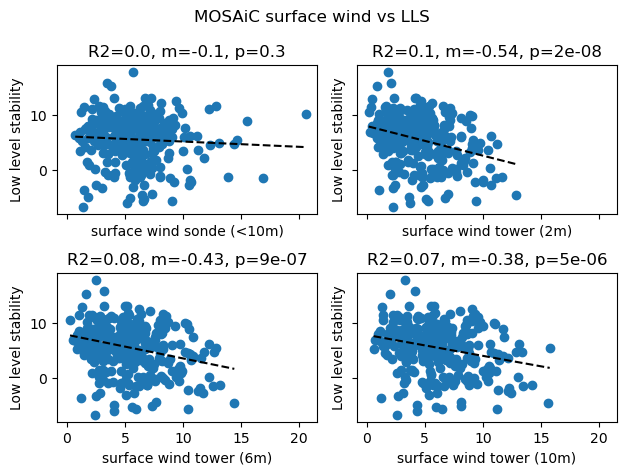

In [70]:
wind_vars = ['surf_wind_velocity', 'wspd_tower_2m', 'wspd_tower_6m', 'wspd_tower_10m']
wind_labels = ['surface wind sonde (<10m)', 'surface wind tower (2m)', 'surface wind tower (6m)', 'surface wind tower (10m)']

fig, axs = plt.subplots(2, 2, sharex=True, sharey=True)

for i in [0, 1, 2, 3]:
    ax = axs.flatten()[i]
    r = lr(DF[wind_vars[i]], DF['low_level_stability'])
    R2, m, p = np.round(r.rvalue**2, 2), np.round(r.slope, 2), '%s' % float('%.1g' % r.pvalue)
    ax.scatter(DF[wind_vars[i]], DF['low_level_stability'])
    ax.set_xlabel(wind_labels[i])
    ax.set_ylabel('Low level stability')
    xs = np.arange(np.min(DF[wind_vars[i]]), np.max(DF[wind_vars[i]]), 0.01)
    ys = r.slope*xs + r.intercept
    ax.plot(xs, ys, c='black', ls='--')
    ax.set_title('R2={R2}, m={m}, p={p}'.format(R2=R2, m=m, p=p))

plt.suptitle('MOSAiC surface wind vs LLS')
plt.tight_layout()

LinregressResult(slope=-0.5434182104030394, intercept=8.042207582591123, rvalue=-0.31606374102595663, pvalue=1.8684158548932894e-08, stderr=0.0940204964709574, intercept_stderr=0.48728469074782416)


Text(0.5, 1.0, 'MOSAiC surface wind vs LLS; R2=0.1, m=-0.54, p=2e-08')

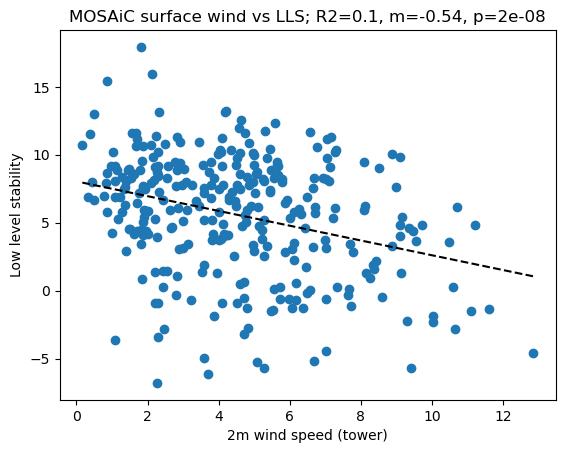

In [67]:
wind_vars = ['surf_wind_velocity', 'wspd_tower_2m']
wind_labels = ['surface wind tower (2m)', 'surface wind sonde']

r = lr(DF['wspd_tower_2m'], DF['low_level_stability'])
R2, m, p = np.round(r.rvalue**2, 2), np.round(r.slope, 2), '%s' % float('%.1g' % r.pvalue)
print(r)
plt.scatter(DF['wspd_tower_2m'], DF['low_level_stability'])
plt.xlabel('2m wind speed (tower)')
plt.ylabel('Low level stability')
xs = np.arange(np.min(DF['wspd_tower_2m']), np.max(DF['wspd_tower_2m']), 0.01)
ys = r.slope*xs + r.intercept
plt.plot(xs, ys, c='black', ls='--')
plt.title('MOSAiC surface wind vs LLS; R2={R2}, m={m}, p={p}'.format(R2=R2, m=m, p=p))


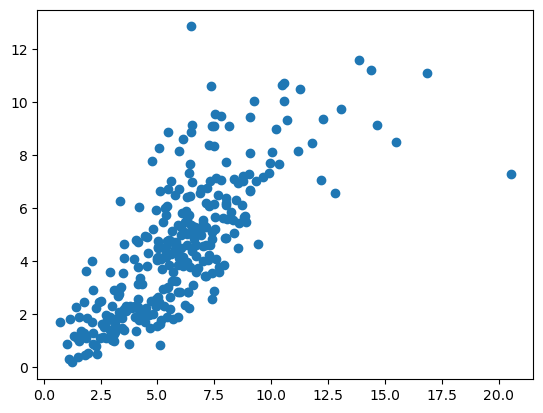

In [75]:
plt.scatter(DF['surf_wind_velocity'], DF['wspd_tower_2m'])